In [ ]:
!pip3 install tensorflow
!pip install keras-tuner   #to decide how many dense layers are to be used

In [3]:
import keras_tuner 

Using TensorFlow backend


In [35]:
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [5]:
print(tf.__version__)

2.14.0


In [6]:
import numpy as np
train = np.loadtxt('train.csv', skiprows=1, delimiter=',') # add dtype=int if it shows error in colab
test=np.loadtxt('test.csv',skiprows=1,delimiter=',')

In [ ]:
train[0]  #1st row- includes train label+train image 

In [9]:
train_labels = train[:,0] # for last column
train_images = train[:,1 :] # for all but last column
test_images = test[:,:] # for last column

In [7]:
print(train.shape,test.shape)
print(len(train[13190]))

(42000, 785) (28000, 784)
785


In [10]:
train_labels[0:10]  #print first 10 train labels

array([1., 0., 1., 4., 0., 0., 7., 3., 5., 3.])

In [40]:
# %%time
# count={}
# for i in train_labels:
# #     i=str(i)
#     if i in count:
#         count[i]+=1
#     else:
#         count[i]=1

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [44]:
train_images.shape
len(train[22946])

785

In [12]:
train_images=train_images.reshape(len(train_images),28,28,1) #42000 rows/dataset, each row having a array of 28*28 i.e 28 rows and 28 columns in gray scale-1, 3 for colour.   Also try to see for (len(train_images),28,14,2) 
test_images=test_images.reshape(len(test_images),28,28,1)


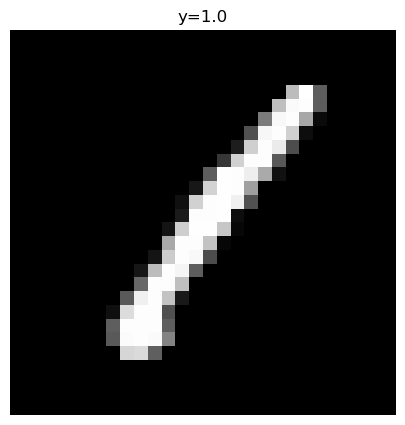

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
# for i in range(20):

plt.imshow(train_images[0],cmap='gray')
plt.title('y={}'.format(train_labels[0]))
plt.axis('off')
    
# plt.tight_layout()
plt.show()

In [15]:
train_images=train_images/255.0  #feature scaling b/w 0-1 to train the images easily
test_images=test_images/255.0

In [17]:
train_images[0].shape

(28, 28, 1)

In [18]:
# train_images[0]

In [19]:
def build_model(hp):
    model= keras.Sequential([
                    keras.layers.Conv2D(filters=hp.Int('conv_1_filter',min_value=32,max_value=128,step=16), #32 filters/kernels
                                         kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),
                                         activation='relu',
                                         input_shape=(28,28,1)
                                         ),

                    #adding second convolutional layer bec it helps in finding features in pictures in a better way/ more precise manner
                    keras.layers.Conv2D(
                        filters=hp.Int('conv_2_filter',min_value=32,max_value=128,step=16),
                        kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),
                        activation='relu'
                    ),
#                     keras.layers.Conv2D(
#                         filters=hp.Int('conv_3_filter',min_value=32,max_value=128,step=16),
#                         kernel_size=hp.Choice('conv_3_kernel',values=[3,5]),
#                         activation='relu'
#                     ),
                    keras.layers.Flatten(), #flatenning all the values of multiple small matrices after max pooling into a single vector column whihc acts as an input layer for ANN then
                    keras.layers.Dense(
                        units=hp.Int('dense_1_units',min_value=32,max_value=128,step=16),
                        activation='relu'
                    ),
                    keras.layers.Dense(10,activation='softmax')
                    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


In [20]:
from kerastuner import RandomSearch  #to check which hyperparametrs are good for our model
# from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.engine.hyperparameters import HyperParameter
# from kerastuner.engine.hyperparameters import Hyperparameters

/var/folders/k8/lsx1j9kj7p55q4qrhnfpz11r0000gn/T/ipykernel_8145/212572501.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch  #to check which hyperparametrs are good for our model


In [24]:
tuner_search= RandomSearch(build_model,objective='val_accuracy', max_trials=5,directory='output', project_name='digit recognition')

Reloading Tuner from output/digit recognition/tuner0.json


In [25]:
tuner_search.search(train_images,train_labels,epochs=3,validation_split=0.1) #default value of epochs=2

Trial 6 Complete [00h 03m 45s]
val_accuracy: 0.9850000143051147

Best val_accuracy So Far: 0.9892857074737549
Total elapsed time: 00h 03m 45s


In [26]:
model=tuner_search.get_best_models(num_models=1)[0]  

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 112)               1734768   
                                                                 
 dense_1 (Dense)             (None, 10)                1130      
                                                                 
Total params: 1756026 (6.70 MB)
Trainable params: 1756026 (6.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
#output shape: (batch size, height, weight, depth). Here it is convo2d layer as (none,24,24,64). Since there are no batches we now in advance so none, else when we change the batch size, it will change

In [30]:
model.fit(train_images,train_labels,epochs=12,validation_split=0.1, initial_epoch=9) 
#to check for 10 epochs, when first 3 epochs we have already done. Epoch at which to start training (useful for resuming a previous training run).
#mostly useful when you have trained your model for some epochs, say 10, and then saved it and now you want to load it and resume the training for another 10 epochs without disrupting the state of epoch-dependent objects (e.g. optimizer)

Epoch 10/12
1182/1182 [==============================] - 25s 21ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0611 - val_accuracy: 0.9876
Epoch 11/12
1182/1182 [==============================] - 24s 21ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0634 - val_accuracy: 0.9869
Epoch 12/12
1182/1182 [==============================] - 25s 21ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0833 - val_accuracy: 0.9876


In [69]:
result=model.predict(test_images)

875/875 [==============================] - 4s 5ms/step


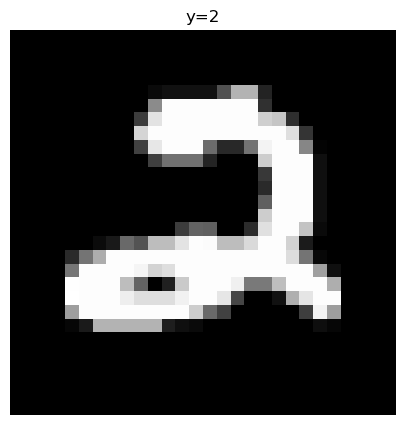

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
# for i in range(20):

plt.imshow(test_images[0],cmap='gray')
plt.title('y={}'.format(np.argmax(result[0])))
plt.axis('off')
    
# plt.tight_layout()
plt.show()

In [161]:
result.shape

(28000, 10)

In [164]:
result2=model.predict(train_images)
for i in range(30):
    print(np.argmax(result2[i]),train_labels[i])

1313/1313 [==============================] - 6s 5ms/step
1 1.0
0 0.0
1 1.0
4 4.0
0 0.0
0 0.0
7 7.0
3 3.0
5 5.0
3 3.0
8 8.0
9 9.0
1 1.0
3 3.0
3 3.0
1 1.0
2 2.0
0 0.0
7 7.0
5 5.0
8 8.0
6 6.0
2 2.0
0 0.0
2 2.0
3 3.0
6 6.0
9 9.0
9 9.0
7 7.0
